In [1]:
from google.colab import drive
import shutil
import torch
from torchvision import transforms, model s
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch import Tensor
from typing import Optional, Sequence

Dataset

In [2]:
drive.mount ('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
batch_size = 4

Loading the dataset

In [4]:
img_size = 256
dataset_path = '/content/gdrive/MyDrive/Train-Test-Val/'

In [5]:
# Transformer to tensor

transformer=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
])

def load_dataset(d_path):
    train_dataset_manual = torchvision.datasets.ImageFolder(d_path, transform=transformer)
    train_loader_manual = torch.utils.data.DataLoader(train_dataset_manual)
    return train_loader_manual

train_dataset = load_dataset(str(dataset_path + 'train')).dataset
test_dataset = load_dataset(str(dataset_path + 'test')).dataset
valid_dataset = load_dataset(str(dataset_path + 'val')).dataset

train_dataset = torch.utils.data.ConcatDataset ([train_dataset, test_dataset])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

train_count = len(train_dataset)
valid_count = len(valid_dataset)

print('Train Set- ' + str(len(train_dataset)) + ' images in ' + str(len(train_loader)) +' batches')
print('Validation Set - ' + str(len(valid_dataset)) + ' images in ' + str(len(valid_loader)) + ' batches')

Train Set- 6175 images in 1544 batches
Validation Set - 1388 images in 347 batches


Model

In [6]:
num_classes = 7

In [7]:
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
model= models.efficientnet_b0(pretrained=True)
model.classifier = nn.Linear(1280, num_classes)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 123MB/s] 


In [9]:
if torch.cuda.is_available():
    model.cuda()

Trainable Parameters

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print ("Number of Trainable Parameters -", total_params)

Number of Trainable Parameters - 4016515


Training

In [12]:
num_epochs = 15
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
loss_function=nn.CrossEntropyLoss()

In [13]:
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()

    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
            
        optimizer.zero_grad()
        
        outputs=model(images)

        loss=loss_function(outputs,labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))

        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on validation dataset
    model.eval()
    
    valid_accuracy = 0.0
    valid_loss = 0.0

    for i, (images,labels) in enumerate(valid_loader):
        images, labels = images.to(device), labels.to(device)
            
        outputs=model(images)

        loss = loss_function (outputs, labels)
        _,prediction=torch.max(outputs.data,1)
        valid_accuracy += int(torch.sum(prediction == labels.data))
        valid_loss+= loss.item()
        
    valid_accuracy = valid_accuracy/valid_count
    valid_loss = valid_loss/valid_count
        
    print('Epoch: %d Train Accuracy: %.5f Train Loss: %.5f Validation Accuracy: %.5f  Validation Loss: %.5f' % (epoch, train_accuracy, train_loss, valid_accuracy, valid_loss))

Epoch: 0 Train Accuracy: 0.79320 Train Loss: 0.15826 Validation Accuracy: 0.92291  Validation Loss: 0.06075
Epoch: 1 Train Accuracy: 0.93684 Train Loss: 0.05213 Validation Accuracy: 0.95317  Validation Loss: 0.03781
Epoch: 2 Train Accuracy: 0.96324 Train Loss: 0.02989 Validation Accuracy: 0.91282  Validation Loss: 0.07358
Epoch: 3 Train Accuracy: 0.97717 Train Loss: 0.01971 Validation Accuracy: 0.97622  Validation Loss: 0.02006
Epoch: 4 Train Accuracy: 0.98105 Train Loss: 0.01686 Validation Accuracy: 0.97622  Validation Loss: 0.02036
Epoch: 5 Train Accuracy: 0.98397 Train Loss: 0.01271 Validation Accuracy: 0.95821  Validation Loss: 0.04388
Epoch: 6 Train Accuracy: 0.98543 Train Loss: 0.01181 Validation Accuracy: 0.96037  Validation Loss: 0.03837
Epoch: 7 Train Accuracy: 0.98785 Train Loss: 0.01044 Validation Accuracy: 0.98127  Validation Loss: 0.01943
Epoch: 8 Train Accuracy: 0.99012 Train Loss: 0.00890 Validation Accuracy: 0.97046  Validation Loss: 0.02612
Epoch: 9 Train Accuracy: 0.9

In [14]:
#Save the model
save_path = '/content/gdrive/MyDrive/Train-Test-Val/EffNet-E15'
torch.save(model, save_path)

Testing

In [15]:
#Load latest model
save_path = '/content/gdrive/MyDrive/Train-Test-Val/EffNet-E15'
model = torch.load(save_path)

In [16]:
#path for testing dataset
dataset_path = '/content/gdrive/MyDrive/Train-Test-Val/test'

In [17]:
batch_size = 9

In [18]:
test_dataset = load_dataset(str(dataset_path)).dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
print('Testing Set - ' + str(len(test_dataset)) + ' images in ' + str(len(test_loader)) + ' batches' )

Testing Set - 2007 images in 223 batches


In [19]:
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [20]:
y_pred = []
y_true = []

# iterate over test data
for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)

    output = model(images) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1])
    output = output.data.cpu().numpy()

    y_pred.extend(output) # Save Prediction
        
    labels1 = labels.data.cpu().numpy()
    y_true.extend(labels1) # Save Truth

Metrics

In [21]:
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [22]:
r = classification_report(y_true, y_pred,zero_division=0,output_dict=True)

In [23]:
print ('Accuracy - ', r.get ('accuracy'))
print ('Weighted Average - ', r.get('weighted avg'))
print ('Macro Average - ', r.get('macro avg'))

Accuracy -  0.9930244145490782
Weighted Average -  {'precision': 0.9931512337736753, 'recall': 0.9930244145490782, 'f1-score': 0.9930218456118203, 'support': 2007}
Macro Average -  {'precision': 0.9905907749179511, 'recall': 0.9921919602165872, 'f1-score': 0.9912889772505752, 'support': 2007}


ROC Curve

In [24]:
model.eval()
y_test = []
y_score = []

In [25]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        #print (i)
        inputs, classes = inputs.to(device), classes.to(device)
        y_test.append(F.one_hot(classes.cpu(), 7).numpy())
        
        try:
            bs, ncrops, c, h, w = inputs.size()
        except:
            bs, c, h, w = inputs.size()
            ncrops = 1
        outputs = model(inputs)
        
        y_score.append(outputs.cpu().numpy())

In [26]:
y_test = np.array([t.ravel() for t in y_test], dtype='object')
y_score = np.array([t.ravel() for t in y_score], dtype='object')

In [27]:
y_test = y_test.astype('float')
y_score = y_score.astype('float')

In [28]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
local_roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]),np.array(y_score[:, i]))
    #fpr[i], tpr[i], _ = roc_curve(np.array(y_test[i]),np.array(y_score[i]))
    local_roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [29]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
local_roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(7)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(7):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

In [30]:
# Finally average it and compute AUC
mean_tpr /= 7
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
local_roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

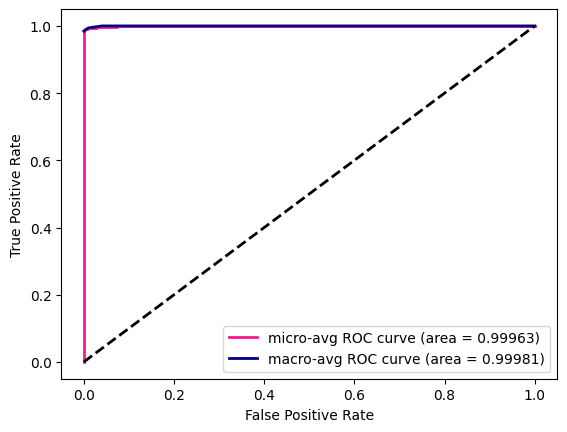

In [31]:
import matplotlib.pyplot as plt
import itertools

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-avg ROC curve (area = {0:0.5f})'
               ''.format(local_roc_auc["micro"]),
         color='deeppink', linewidth=2)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-avg ROC curve (area = {0:0.5f})'
               ''.format(local_roc_auc["macro"]),
         color='navy', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('samplefigure', bbox_inches='tight')

AUC Values

In [32]:
print ("AUC - MicroAvg: ", local_roc_auc["micro"])
print ("AUC - MacroAvg: ", local_roc_auc["macro"])

AUC - MicroAvg:  0.999630880028189
AUC - MacroAvg:  0.9998059493898062
